<a href="https://colab.research.google.com/github/MorgooN/ML-Labs/blob/main/TNN_Morg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Zrenye'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Zrenye/cs231n/datasets
/content/drive/My Drive/Zrenye


# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [4]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [5]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [6]:
# Test the affine_forward function
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x_reshaped = x.reshape(x.shape[0], -1)
    out = x_reshaped @ w + b

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [8]:
# Test the affine_backward function
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x_reshaped = x.reshape(x.shape[0], -1)
    dx = (dout @ w.T).reshape(x.shape[0], *x.shape[1:])
    dw = x_reshaped.T @ dout
    db = dout.sum(axis=0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [11]:
# Test the relu_forward function

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    out = np.maximum(0, x)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [12]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dx = dout * (x > 0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1:

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer: `1`, `2`





# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [15]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward

def affine_relu_forward(x, w, b):
    """
    Convenience layer that perorms an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `cs231n/layers.py`. These should be similar to what you implemented in `cs231n/classifiers/softmax.py` and `cs231n/classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [16]:
def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None
    ###########################################################################
    # TODO: Implement loss and gradient for multiclass SVM classification.    #
    # This will be similar to the svm loss vectorized implementation in       #
    # cs231n/classifiers/linear_svm.py.                                       #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N = len(y)                                # number of samples
    x_true = x[range(N), y][:, None]          # scores for true labels
    margins = np.maximum(0, x - x_true + 1)   # margin for each score
    loss = margins.sum() / N - 1
    dx = (margins > 0).astype(float) / N
    dx[range(N), y] -= dx.sum(axis=1)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None
    ###########################################################################
    # TODO: Implement the loss and gradient for softmax classification. This  #
    # will be similar to the softmax loss vectorized implementation in        #
    # cs231n/classifiers/softmax.py.                                          #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N = len(y) # number of samples

    P = np.exp(x - x.max(axis=1, keepdims=True)) # numerically stable exponents
    P /= P.sum(axis=1, keepdims=True)            # row-wise probabilities (softmax)

    loss = -np.log(P[range(N), y]).sum() / N # sum cross entropies as loss

    P[range(N), y] -= 1
    dx = P / N

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return loss, dx

np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.3025458445007376
dx error:  8.234144091578429e-09


# Two-layer network
Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [17]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(
        self,
        input_dim=3 * 32 * 32,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-3,
        reg=0.0,
    ):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.params = {
          'W1': np.random.randn(input_dim, hidden_dim) * weight_scale,
          'b1': np.zeros(hidden_dim),
          'W2': np.random.randn(hidden_dim, num_classes) * weight_scale,
          'b2': np.zeros(num_classes)
        }

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        W1, b1, W2, b2 = self.params.values()

        out1, cache1 = affine_forward(X, W1, b1)
        out2, cache2 = relu_forward(out1)
        scores, cache3 = affine_forward(out2, W2, b2)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        loss, dloss = softmax_loss(scores, y)
        loss += 0.5 * self.reg * (np.sum(W1**2) + np.sum(W2**2))

        dout3, dW2, db2 = affine_backward(dloss, cache3)
        dout2 = relu_backward(dout3, cache2)
        dout1, dW1, db1 = affine_backward(dout2, cache1)

        dW1 += self.reg * W1
        dW2 += self.reg * W2

        grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.20e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. You also need to imeplement the `sgd` function in `cs231n/optim.py`. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [20]:
from __future__ import print_function, division

from builtins import range
from builtins import object
import os
import pickle as pickle

import numpy as np

from cs231n import optim


class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules defined in optim.py.

    The solver accepts both training and validation data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various options (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'y_val': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        # Unpack keyword arguments
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optim, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": self.update_rule,
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_train_samples": self.num_train_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "train_acc_history": self.train_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print(
                        "(Epoch %d / %d) train acc: %f; val_acc: %f"
                        % (self.epoch, self.num_epochs, train_acc, val_acc)
                    )

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(model, data, optim_config={'learning_rate': 1e-3})
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.302908
(Epoch 0 / 10) train acc: 0.091000; val_acc: 0.096000
(Iteration 11 / 4900) loss: 2.278751
(Iteration 21 / 4900) loss: 2.179128
(Iteration 31 / 4900) loss: 2.076715
(Iteration 41 / 4900) loss: 2.018797
(Iteration 51 / 4900) loss: 2.073024
(Iteration 61 / 4900) loss: 1.982857
(Iteration 71 / 4900) loss: 1.959678
(Iteration 81 / 4900) loss: 1.911645
(Iteration 91 / 4900) loss: 1.805223
(Iteration 101 / 4900) loss: 1.838519
(Iteration 111 / 4900) loss: 1.746668
(Iteration 121 / 4900) loss: 1.785310
(Iteration 131 / 4900) loss: 1.736591
(Iteration 141 / 4900) loss: 1.842648
(Iteration 151 / 4900) loss: 1.698033
(Iteration 161 / 4900) loss: 1.756839
(Iteration 171 / 4900) loss: 1.629959
(Iteration 181 / 4900) loss: 1.679774
(Iteration 191 / 4900) loss: 1.706090
(Iteration 201 / 4900) loss: 1.876793
(Iteration 211 / 4900) loss: 1.711376
(Iteration 221 / 4900) loss: 1.792503
(Iteration 231 / 4900) loss: 1.658745
(Iteration 241 / 4900) loss: 1.573331
(Iterat

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

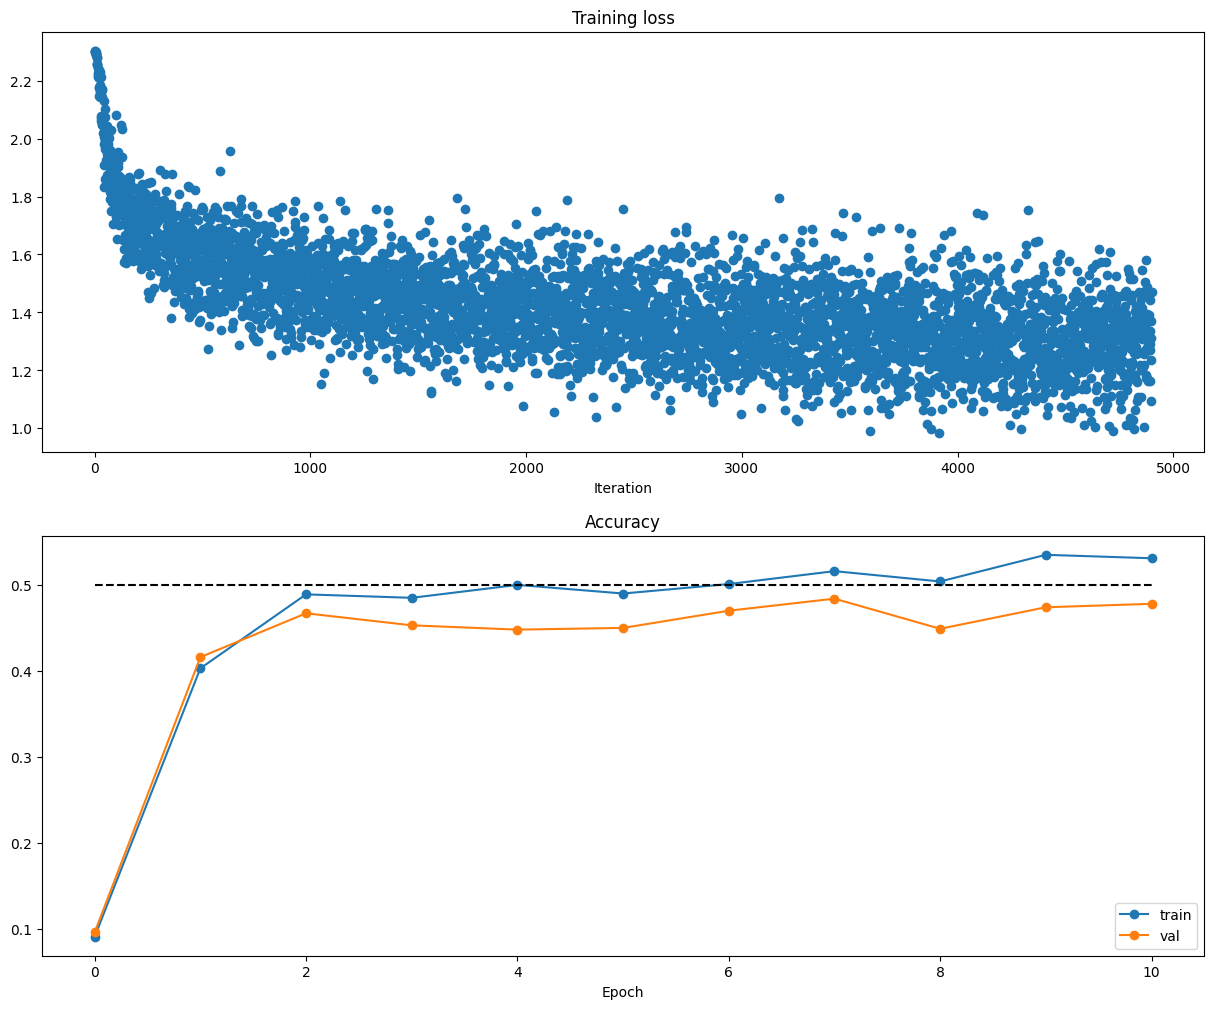

In [21]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

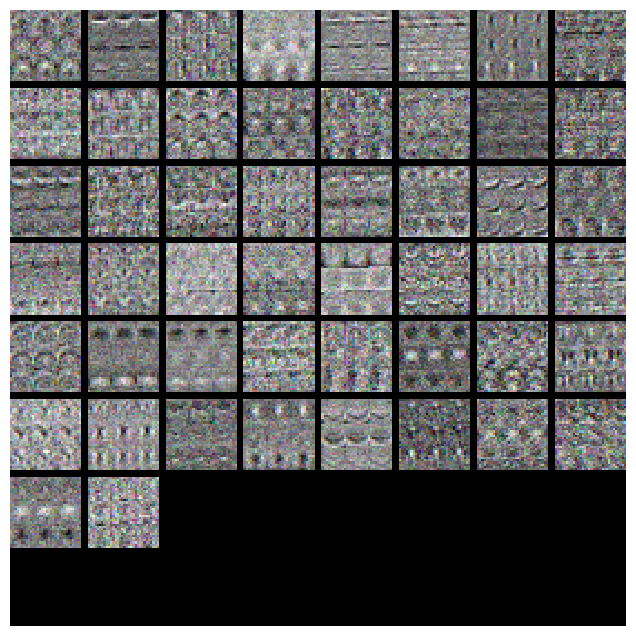

In [22]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [24]:
best_model = None


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results = {}
best_val = -1

learning_rates = np.geomspace(3e-4, 3e-2, 3)
regularization_strengths = np.geomspace(1e-6, 1e-2, 5)

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create Two Layer Net and train it with Solver
    model = TwoLayerNet(hidden_dim=128, reg=reg)
    solver = Solver(model, data, optim_config={'learning_rate': lr}, num_epochs=10, verbose=False)
    solver.train()

    # Compute validation set accuracy and append to the dictionary
    results[(lr, reg)] = solver.best_val_acc

    # Save if validation accuracy is the best
    if results[(lr, reg)] > best_val:
        best_val = results[(lr, reg)]
        best_model = model

# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

<ipython-input-16-061b0b0c0015>:64: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(P[range(N), y]).sum() / N # sum cross entropies as loss
<ipython-input-16-061b0b0c0015>:61: RuntimeWarning: overflow encountered in subtract
  P = np.exp(x - x.max(axis=1, keepdims=True)) # numerically stable exponents
<ipython-input-6-0759ce4f1749>:28: RuntimeWarning: overflow encountered in matmul
  out = x_reshaped @ w + b
<ipython-input-16-061b0b0c0015>:61: RuntimeWarning: invalid value encountered in subtract
  P = np.exp(x - x.max(axis=1, keepdims=True)) # numerically stable exponents


lr 3.000000e-04 reg 1.000000e-06 val accuracy: 0.515000
lr 3.000000e-04 reg 1.000000e-05 val accuracy: 0.518000
lr 3.000000e-04 reg 1.000000e-04 val accuracy: 0.520000
lr 3.000000e-04 reg 1.000000e-03 val accuracy: 0.530000
lr 3.000000e-04 reg 1.000000e-02 val accuracy: 0.537000
lr 3.000000e-03 reg 1.000000e-06 val accuracy: 0.350000
lr 3.000000e-03 reg 1.000000e-05 val accuracy: 0.174000
lr 3.000000e-03 reg 1.000000e-04 val accuracy: 0.318000
lr 3.000000e-03 reg 1.000000e-03 val accuracy: 0.293000
lr 3.000000e-03 reg 1.000000e-02 val accuracy: 0.373000
lr 3.000000e-02 reg 1.000000e-06 val accuracy: 0.218000
lr 3.000000e-02 reg 1.000000e-05 val accuracy: 0.135000
lr 3.000000e-02 reg 1.000000e-04 val accuracy: 0.126000
lr 3.000000e-02 reg 1.000000e-03 val accuracy: 0.140000
lr 3.000000e-02 reg 1.000000e-02 val accuracy: 0.180000
best validation accuracy achieved during cross-validation: 0.537000


# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [25]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.537


In [26]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.533


## Inline Question 2:

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$

`1`, `3`

$\color{blue}{\textit Your Explanation:}$

Чем больше датасет, тем эффективнее обучение нейросети, что позволяет избежать проблемы переобучения.- 1. 3 - Регуляризация также помогает против переобучения посредством упрощения модели
